# Import Module

In [1]:
import random
import pandas as pd
import numpy as np

from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.figure import figaspect

# Import Data

In [2]:
data = pd.read_csv('Netflix_Dataset_Rating.csv')
data

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


# Functions

## Data Manipulation

In [3]:
def fill_nan_with_row_average(row):
    row_mean = np.nanmean(row)  
    
    return row.fillna(row_mean) 

## Objective Function

In [4]:
# Fungsi objektif akurasi
def func_objective_1(user, 
                     item):
    
    total = 0
    n_iter = len(item)
    for i in range(n_iter):
        total += cosine_similarity(user.reshape(1, -1), item[i].reshape(1, -1))

    total = total / len(item)

    return -total[0, 0]

'------------------------------------------------------------------------------------------------------------------'

# Fungsi objektif sparsity
def func_objective_2(item):
    
    total = 0
    for i in range(len(item)):
        for j in range(len(item)):
            if i != j:
                total += cosine_similarity(item[i].reshape(1, -1), item[j].reshape(1, -1))

    total = total / (len(item) * (len(item) - 1))

    return total[0, 0]

'------------------------------------------------------------------------------------------------------------------'

# Fungsi multiobjektif
def calculate_affinity(user, 
                       item, 
                       population):
    
    res = []
    for recommendations in population:
        temp = item[recommendations]

        f1 = func_objective_1(user, temp)
        f2 = func_objective_2(temp)

        res.append([f1, f2])
        
    return np.array(res)

## MOGA

### Fitness

In [5]:
# Rank
def determine_rank(user, 
                   item, 
                   population):
    
    # Menghitung nilai fungsi objektif dari masing-masing list rekomendasi
    affinity = calculate_affinity(user, item, population)
    
    # Inisiasi rank
    ranks = [1 for _ in range(len(population))]
    for i in range(len(population)):
        for j in range(len(population)):
            # Jika untuk 2 list rekomendasi berbeda, rekomendasi j memiliki fungsi objektif yang lebih baik,
            # maka rank rekomendasi i akan bertambah 1
            if i != j:
                if (affinity[j][0] < affinity[i][0]) and (affinity[j][1] < affinity[i][1]):
                    ranks[i] += 1
        
    return ranks

'------------------------------------------------------------------------------------------------------------------'

# Average fitness
def average_fitness(ranks):
    
    # Banyak rekomendasi item
    N = len(ranks)
    
    # Inisiasi nilai average fitness
    F = [N - 0.5 * (ranks.count(ranks[i]) - 1) for i in range(N)]
    
    # Perhitungan lainnya
    for i in range(N):
        for j in range(ranks[i]):
            F[i] -= ranks.count(j)
            
    return F

'------------------------------------------------------------------------------------------------------------------'

# Normalized distance
def normalized_distance(ranks, 
                        affinity, 
                        fmins,
                        fmaxs):
    
    # Banyak rekomendasi
    N = len(ranks)
    
    # Inisiasi distance rekomendasi i dan j
    dist = [[0 for j in range(N)] for i in range(N)]
    
    for rank in [1]:
        # Menghitung normalized distance untuk masing-masing rank
        for i in range(N):
            for j in range(N):
                # Lanjutkan perhitungan jika dan hanya jika rank rekomendasi ke-i sama dengan rank rekomendasi ke-j
                if ranks[i] == ranks[j]:
                    for k in range(len(fmins)):
                        dist[i][j] += ((affinity[i][k] - affinity[j][k]) / (fmaxs[k] - fmins[k])) ** 2

                    dist[i][j] = np.sqrt(dist[i][j])
                    
    return dist

'------------------------------------------------------------------------------------------------------------------'

# Sharing function values
def sharing_function(ranks, 
                     dist,
                     share):
    
    # Banyak rekomendasi
    N = len(ranks)
    
    # Inisiasi matriks sharing function values
    sh = dist.copy()
    
    # Proses perhitungan
    for i in range(N):
        for j in range(N):
            # Lanjutkan perhitungan jika dan hanya jika rank rekomendasi ke-i sama dengan rank rekomendasi ke-j
            if ranks[i] == ranks[j]:
                if dist[i][j] <= share:
                    sh[i][j] = 1 - dist[i][j] / share
                    
                else:
                    sh[i][j] = 0
                    
    return sh

'------------------------------------------------------------------------------------------------------------------'

# Niche counts
def niche_counts(sh):
    
    return np.sum(sh, axis = 1)

'------------------------------------------------------------------------------------------------------------------'

# Shared fitness
def shared_fitness(F,
                   sh):
    
    return np.array(F) / np.array(sh)

'------------------------------------------------------------------------------------------------------------------'

# Scaled fitness
def scaled_fitness(ranks,
                   F,
                   sf):
    
    # Banyak rekomendasi
    N = len(ranks)
    
    # Inisiasi total shared fitness untuk tiap rank
    total = [F[i] * ranks.count(ranks[i]) for i in range(N)]
    
    # Inisiasi faktor scaling
    scaler = [0 for i in range(N)]
    
    # Perhitungan faktor scaling untuk tiap rekomendasi
    for i in range(N):
        scaler[i] = sum([sf[j] for j in range(N) if ranks[i] == ranks[j]])
        
    return np.array(sf) * np.array(total) / np.array(scaler)

### Genetic Algorithm

In [21]:
# Selection
def select_parent(population,
                  scaled_fitness):
    
    # Menghitung probabilitas setiap list rekomendasi terpilih sebagai parent
    scaled_prob = scaled_fitness / sum(scaled_fitness)
    
    # Menentukan parents berdasarkan random choice
    indices = np.arange(len(population))
    parents_idx = np.random.choice(indices, p = scaled_prob, size = 2, replace = False)

    return parents_idx

'------------------------------------------------------------------------------------------------------------------'

# Random crossover
def random_cross(parents, 
                 cross_prob = 0.5):
    
    # Mendefinisikan parent 1 dan 2
    parent_1 = parents[0]
    parent_2 = parents[1]
    
    # Random indeks untuk proses one point crossover
    cross_index = np.random.randint(0, len(parent_1))
    
    # Random probabilitas untuk menentukan apakah cross over terjadi
    is_cross = False
    if np.random.random() < cross_prob:
        is_cross = True
        
    # Jika terjadi crossover, lakukan one point crossover pada indeks cross_index pada kedua parent
    if is_cross:
        child_1 = parent_1[:cross_index] + parent_2[cross_index:]
        child_2 = parent_2[:cross_index] + parent_2[cross_index:]
        
        # Prosedur untuk memastikan bahwa tidak ada elemen yang repetitif pada child 1 dan 2
        # Jika ada, pilih secara random
        for i in range(len(child_1)):
            # Jika ada elemen di child 1 yang repetitif, pilih secara random dari child 2
            if child_1[i] in child_1[:i]:
                while True:
                    new_rec = np.random.choice(child_2)
                    if new_rec not in child_1[:i]:
                        child_1[i] = new_rec
                        break

            # Lakukan hal serupa untuk child 2
            if child_2[i] in child_2[:i]:
                while True:
                    new_rec = np.random.choice(child_1)
                    if new_rec not in child_2[:i]:
                        child_2[i] = new_rec
                        break
     
    # Jika tidak terjadi crossover, maka childs sama dengan parents
    else:
        child_1 = parent_1
        child_2 = parent_2
                    
    return [child_1, child_2]

'------------------------------------------------------------------------------------------------------------------'

# Random mutation
def random_mutate(childs, 
                  mute_prob = 0.2,
                  minv = 0,
                  maxv = 30):
    
    # Lakukan mutasi untuk kedua child dari proses crossover
    for i in range(len(childs)):
        # Random indeks untuk proses single mutation
        mute_index = np.random.randint(0, len(childs))
        
        # Random probabilitas untuk menentukan apakah mutasi terjadi
        is_mute = False
        if np.random.random() < mute_prob:
            is_mute = True
            
        # Jika terjadi mutasi, lakukan single point mutation dengan memilih secara random suatu item rekomendasi
        if is_mute:
            # Rekomendasikan suatu item yang tidak ada pada list item rekomendasi child i
            while True:
                new_rec = np.random.randint(minv, maxv)
                if new_rec not in childs[i]:
                    childs[i][mute_index] = new_rec
                    break
                    
    return childs 

In [7]:
affinity = [[0.31, 6.1], [0.43, 6.79], [0.22, 7.09], [0.59, 7.85], [0.66, 3.65], [0.83, 4.23]]
ranks = [1, 2, 1, 4, 1, 2]
fmins = [0.1, 1]
fmaxs = [1, 10]

In [8]:
F = average_fitness(ranks)
F

[5.0, 2.5, 5.0, 1.0, 5.0, 2.5]

In [9]:
dist = normalized_distance(ranks, affinity, fmins, fmaxs)
dist

[[0.0, 0, 0.14866068747318506, 0, 0.47469938505631065, 0],
 [0, 0.0, 0, 0, 0, 0.5276736739433183],
 [0.14866068747318506, 0, 0.0, 0, 0.6205692329140289, 0],
 [0, 0, 0, 0.0, 0, 0],
 [0.47469938505631065, 0, 0.6205692329140289, 0, 0.0, 0],
 [0, 0.5276736739433183, 0, 0, 0, 0.0]]

In [10]:
sh = sharing_function(ranks, dist, 0.5)
sh

[[1.0, 0, 0.7026786250536299, 0, 0.050601229887378696, 0],
 [0, 1.0, 0, 0, 0, 0],
 [0.7026786250536299, 0, 1.0, 0, 0, 0],
 [0, 0, 0, 1.0, 0, 0],
 [0.050601229887378696, 0, 0, 0, 1.0, 0],
 [0, 0, 0, 0, 0, 1.0]]

In [11]:
nc = niche_counts(sh)
nc

array([1.75327985, 1.        , 1.70267863, 1.        , 1.05060123,
       1.        ])

In [12]:
sf = shared_fitness(F, nc)
sf

array([2.85179801, 2.5       , 2.93654946, 1.        , 4.75917966,
       2.5       ])

In [13]:
sc_f = scaled_fitness(ranks, F, sf)
sc_f

array([4.05563974, 2.5       , 4.17616768, 1.        , 6.76819258,
       2.5       ])

# Data Preparation

In [14]:
# Pick 40 random movies
random_40_movies = data['Movie_ID'].value_counts().index[:40]

# Limit the data only to those movies to speed up computation
temp = data.loc[data['Movie_ID'].isin(random_40_movies)] 

# Top 300 most rating users who rated these movies
top_300_most_rating_users = data.loc[data['Movie_ID'].isin(random_40_movies)]['User_ID'].value_counts().index[:300]

# Limit the data only to those movies and users to speed up computation
temp = temp.loc[data['User_ID'].isin(top_300_most_rating_users)] 

## Pivot Table

In [15]:
R_matrix = pd.pivot_table(temp, values = 'Rating', index = 'User_ID', columns = 'Movie_ID')
R_matrix.index = np.arange(len(R_matrix))
R_matrix.columns = np.arange(len(R_matrix.columns))

R_matrix

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,2,4,4,4,5,4,4,4,5,3,...,4,4,4,4,5,4,4,4,4,4
1,3,4,5,5,3,5,3,4,5,2,...,3,4,4,4,5,4,5,5,5,4
2,5,5,4,4,4,2,5,4,4,5,...,4,4,1,4,5,4,4,4,4,4
3,5,5,4,4,4,5,2,5,4,5,...,5,5,5,5,5,5,5,5,5,1
4,3,4,5,4,2,4,3,3,3,2,...,3,2,4,5,5,4,3,5,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4,4,4,4,4,2,5,4,1,2,...,3,4,5,4,5,5,3,5,5,4
296,5,4,5,4,4,4,5,3,4,4,...,4,4,4,5,5,4,4,5,3,4
297,5,4,3,4,4,5,3,4,4,3,...,4,5,4,5,5,4,4,5,4,3
298,2,4,5,5,4,4,4,5,3,5,...,4,3,3,3,3,3,2,4,4,4


## Missing Value Handling and SVD

In [49]:
# Proses SVD
R_matrix = R_matrix.apply(fill_nan_with_row_average, axis = 1)
U, S, Vt = svd(R_matrix.to_numpy(), full_matrices = True)

# Truncate ke rank k
rank = 10
U = U[:, :rank]
S = S[:rank]
Vt = Vt[:rank, :]

# User dan item feature matrix
M_user_matrix = np.matmul(U, np.diag(S ** 0.5))
N_item_matrix = np.matmul(Vt.T, np.diag(S ** 0.5))


similarity_matrix = cosine_similarity(M_user_matrix, N_item_matrix)

# Recommendation for Specific User

## Initial Solution

In [50]:
# Suppose you want to recommend items for user 0
user_idx = 0
user_similarity_scores = similarity_matrix[user_idx]

# Create initial solutions of recommendation items for user
pop_size = 10
items_to_recommend = 5
R_lists = []
for _ in range(pop_size):
    unique_elements = random.sample(list(np.arange(len(N_item_matrix))), items_to_recommend)
    R_lists.append(unique_elements)
                                    
R_lists

[[4, 30, 13, 7, 6],
 [11, 7, 33, 9, 13],
 [19, 17, 10, 25, 30],
 [11, 0, 23, 5, 10],
 [27, 30, 32, 0, 38],
 [19, 36, 2, 32, 37],
 [38, 26, 12, 16, 13],
 [32, 16, 11, 6, 0],
 [30, 20, 26, 12, 11],
 [32, 37, 6, 29, 21]]

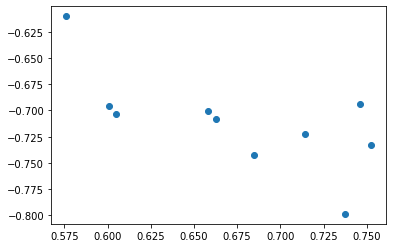

In [51]:
user = M_user_matrix[user_idx]
item = N_item_matrix

affinity = calculate_affinity(user, item, R_lists)

# Plot the initial solution
plt.scatter(affinity[:, 1], affinity[:, 0])

## Optimization

In [52]:
# Konstanta
fmins = [-1, -1]
fmaxs = [0, 0]

max_iter = 500

In [53]:
for i in range(max_iter):    
    ranks = determine_rank(user, item, R_lists)
    F = average_fitness(ranks)
    dist = normalized_distance(ranks, affinity, fmins, fmaxs)
    sh = sharing_function(ranks, dist, 0.5)
    nc = niche_counts(sh)
    sf = shared_fitness(F, nc)
    sc_f = scaled_fitness(ranks, F, sf)

    parents_indices = select_parent(R_lists, sc_f)
    parents = [R_lists[int(idx)] for idx in parents_indices]
    childs = random_cross(parents)
    childs = random_mutate(childs)
    
    for j in range(len(childs)):
        R_lists[parents_indices[j]] = childs[j]

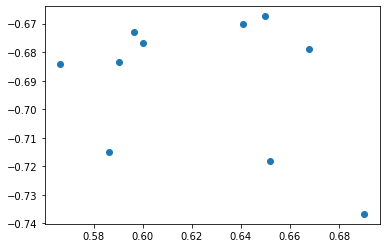

In [54]:
affinity = calculate_affinity(user, item, R_lists)

# Plot the initial solution
plt.scatter(affinity[:, 1], affinity[:, 0])